In [1]:
import cv2
import numpy as np
import os
from scipy.optimize import least_squares
from tomlkit import boolean
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class Image_loader():
    def __init__(self, img_dir:str, downscale_factor:float):
        # loading the Camera intrinsic parameters K
        with open(img_dir + '\\K.txt') as f:
            self.K = np.array(list((map(lambda x:list(map(lambda x:float(x), x.strip().split(' '))),f.read().split('\n')))))
            self.image_list = []
        # Loading the set of images
        for image in sorted(os.listdir(img_dir)):
            if image[-4:].lower() == '.jpg' or image[-5:].lower() == '.png':
                self.image_list.append(img_dir + '\\' + image)
        
        self.path = os.getcwd()
        self.factor = downscale_factor
        self.downscale()

    
    def downscale(self) -> None:
        '''
        Downscales the Image intrinsic parameter acc to the downscale factor
        '''
        self.K[0, 0] /= self.factor
        self.K[1, 1] /= self.factor
        self.K[0, 2] /= self.factor
        self.K[1, 2] /= self.factor
    
    def downscale_image(self, image):
        for _ in range(1,int(self.factor / 2) + 1):
            image = cv2.pyrDown(image)
        return image

In [3]:
def find_features(image_0, image_1):
        '''
        Feature detection using the sift algorithm and KNN
        return keypoints(features) of image1 and image2
        '''

        sift = cv2.xfeatures2d.SIFT_create()
        key_points_0, desc_0 = sift.detectAndCompute(cv2.cvtColor(image_0, cv2.COLOR_BGR2GRAY), None)
        key_points_1, desc_1 = sift.detectAndCompute(cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY), None)

        bf = cv2.BFMatcher()
        matches = bf.knnMatch(desc_0, desc_1, k=2)
        feature = []
        for m, n in matches:
            if m.distance < 0.70 * n.distance:
                feature.append(m)

        return np.float32([key_points_0[m.queryIdx].pt for m in feature]), np.float32([key_points_1[m.trainIdx].pt for m in feature])


In [4]:
def triangulation(point_2d_1, point_2d_2, projection_matrix_1, projection_matrix_2) -> tuple:
        '''
        Triangulates 3d points from 2d vectors and projection matrices
        returns projection matrix of first camera, projection matrix of second camera, point cloud 
        '''
        pt_cloud = cv2.triangulatePoints(point_2d_1, point_2d_2, projection_matrix_1.T, projection_matrix_2.T)
        return projection_matrix_1.T, projection_matrix_2.T, (pt_cloud / pt_cloud[3])    
    

In [5]:
def triangulation(point_2d_1, point_2d_2, projection_matrix_1, projection_matrix_2) -> tuple:
        '''
        Triangulates 3d points from 2d vectors and projection matrices
        returns projection matrix of first camera, projection matrix of second camera, point cloud 
        '''
        pt_cloud = cv2.triangulatePoints(point_2d_1, point_2d_2, projection_matrix_1.T, projection_matrix_2.T)
        return projection_matrix_1.T, projection_matrix_2.T, (pt_cloud / pt_cloud[3]) 

In [6]:
def reprojection_error(obj_points, image_points, transform_matrix, K, homogenity) ->tuple:
        '''
        Calculates the reprojection error ie the distance between the projected points and the actual points.
        returns total error, object points
        '''
        rot_matrix = transform_matrix[:3, :3]
        tran_vector = transform_matrix[:3, 3]
        rot_vector, _ = cv2.Rodrigues(rot_matrix)
        if homogenity == 1:
            obj_points = cv2.convertPointsFromHomogeneous(obj_points.T)
        image_points_calc, _ = cv2.projectPoints(obj_points, rot_vector, tran_vector, K, None)
        image_points_calc = np.float32(image_points_calc[:, 0, :])
        total_error = cv2.norm(image_points_calc, np.float32(image_points.T) if homogenity == 1 else np.float32(image_points), cv2.NORM_L2)
        return total_error / len(image_points_calc), obj_points

In [7]:
def PnP(obj_point, image_point , K, dist_coeff, rot_vector, initial) ->  tuple:
        '''
        Finds an object pose from 3D-2D point correspondences using the RANSAC scheme.
        returns rotational matrix, translational matrix, image points, object points, rotational vector
        '''
        if initial == 1:
            obj_point = obj_point[:, 0 ,:]
            image_point = image_point.T
            rot_vector = rot_vector.T 
        _, rot_vector_calc, tran_vector, inlier = cv2.solvePnPRansac(obj_point, image_point, K, dist_coeff, cv2.SOLVEPNP_ITERATIVE)
        # Converts a rotation matrix to a rotation vector or vice versa
        rot_matrix, _ = cv2.Rodrigues(rot_vector_calc)

        if inlier is not None:
            image_point = image_point[inlier[:, 0]]
            obj_point = obj_point[inlier[:, 0]]
            rot_vector = rot_vector[inlier[:, 0]]
        return rot_matrix, tran_vector, image_point, obj_point, rot_vector

In [8]:
def common_points(image_points_1, image_points_2, image_points_3):
        '''
        Finds the common points between image 1 and 2 , image 2 and 3
        returns common points of image 1-2, common points of image 2-3, mask of common points 1-2 , mask for common points 2-3 
        '''
        cm_points_1 = []
        cm_points_2 = []
        for i in range(image_points_1.shape[0]):
            a = np.where(image_points_2 == image_points_1[i, :])
            if a[0].size != 0:
                cm_points_1.append(i)
                cm_points_2.append(a[0][0])

        mask_array_1 = np.ma.array(image_points_2, mask=False)
        mask_array_1.mask[cm_points_2] = True
        mask_array_1 = mask_array_1.compressed()
        mask_array_1 = mask_array_1.reshape(int(mask_array_1.shape[0] / 2), 2)

        mask_array_2 = np.ma.array(image_points_3, mask=False)
        mask_array_2.mask[cm_points_2] = True
        mask_array_2 = mask_array_2.compressed()
        mask_array_2 = mask_array_2.reshape(int(mask_array_2.shape[0] / 2), 2)
        print(" Shape New Array", mask_array_1.shape, mask_array_2.shape)
        return np.array(cm_points_1), np.array(cm_points_2), mask_array_1, mask_array_2


In [9]:
def to_ply(path, point_cloud, colors,img_obj):
        '''
        Generates the .ply which can be used to open the point cloud
        '''
        
        print("@@@@@@@@@@@@@@@@")
        
        img_obj = img_obj.image_list[0].split('\\')[-2]
        img_obj = img_obj[9:]
        print(img_obj)
        
        
        out_points = point_cloud.reshape(-1, 3) * 200
        out_colors = colors.reshape(-1, 3)
        print(out_colors.shape, out_points.shape)
        verts = np.hstack([out_points, out_colors])


        mean = np.mean(verts[:, :3], axis=0)
        scaled_verts = verts[:, :3] - mean
        dist = np.sqrt(scaled_verts[:, 0] ** 2 + scaled_verts[:, 1] ** 2 + scaled_verts[:, 2] ** 2)
        indx = np.where(dist < np.mean(dist) + 300)
        verts = verts[indx]
        ply_header = '''ply
            format ascii 1.0
            element vertex %(vert_num)d
            property float x
            property float y
            property float z
            property uchar blue
            property uchar green
            property uchar red
            end_header
            '''
        with open(path + '\\res\\' + img_obj + '.ply', 'w') as f:
            f.write(ply_header % dict(vert_num=len(verts)))
            np.savetxt(f, verts, '%f %f %f %d %d %d')


In [10]:
def call(img_obj, enable_bundle_adjustment=False):
        print("!!!")
        print(img_obj)
        print(img_obj.path)
        
        cv2.namedWindow('image', cv2.WINDOW_NORMAL)
        pose_array = img_obj.K.ravel()
        transform_matrix_0 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
        transform_matrix_1 = np.empty((3, 4))
    
        pose_0 = np.matmul(img_obj.K, transform_matrix_0)
        pose_1 = np.empty((3, 4)) 
        total_points = np.zeros((1, 3))
        total_colors = np.zeros((1, 3))

        image_0 = img_obj.downscale_image(cv2.imread(img_obj.image_list[0]))
        image_1 = img_obj.downscale_image(cv2.imread(img_obj.image_list[1]))

        feature_0, feature_1 = find_features(image_0, image_1)

        # Essential matrix
        essential_matrix, em_mask = cv2.findEssentialMat(feature_0, feature_1, img_obj.K, method=cv2.RANSAC, prob=0.999, threshold=0.4, mask=None)
        feature_0 = feature_0[em_mask.ravel() == 1]
        feature_1 = feature_1[em_mask.ravel() == 1]


        _, rot_matrix, tran_matrix, em_mask = cv2.recoverPose(essential_matrix, feature_0, feature_1, img_obj.K)
        feature_0 = feature_0[em_mask.ravel() > 0]
        feature_1 = feature_1[em_mask.ravel() > 0]
        transform_matrix_1[:3, :3] = np.matmul(rot_matrix, transform_matrix_0[:3, :3])
        transform_matrix_1[:3, 3] = transform_matrix_0[:3, 3] + np.matmul(transform_matrix_0[:3, :3], tran_matrix.ravel())

        pose_1 = np.matmul(img_obj.K, transform_matrix_1)

        feature_0, feature_1, points_3d = triangulation(pose_0, pose_1, feature_0, feature_1)
        error, points_3d = reprojection_error(points_3d, feature_1, transform_matrix_1, img_obj.K, homogenity = 1)
        #ideally error < 1
        print("REPROJECTION ERROR: ", error)
        _, _, feature_1, points_3d, _ = PnP(points_3d, feature_1, img_obj.K, np.zeros((5, 1), dtype=np.float32), feature_0, initial=1)

        total_images = len(img_obj.image_list) - 2 
        pose_array = np.hstack((np.hstack((pose_array, pose_0.ravel())), pose_1.ravel()))

        threshold = 0.5
        for i in tqdm(range(total_images)):
            image_2 = img_obj.downscale_image(cv2.imread(img_obj.image_list[i + 2]))
            features_cur, features_2 = find_features(image_1, image_2)

            if i != 0:
                feature_0, feature_1, points_3d = triangulation(pose_0, pose_1, feature_0, feature_1)
                feature_1 = feature_1.T
                points_3d = cv2.convertPointsFromHomogeneous(points_3d.T)
                points_3d = points_3d[:, 0, :]
            

            cm_points_0, cm_points_1, cm_mask_0, cm_mask_1 = common_points(feature_1, features_cur, features_2)
            cm_points_2 = features_2[cm_points_1]
            cm_points_cur = features_cur[cm_points_1]

            rot_matrix, tran_matrix, cm_points_2, points_3d, cm_points_cur = PnP(points_3d[cm_points_0], cm_points_2, img_obj.K, np.zeros((5, 1), dtype=np.float32), cm_points_cur, initial = 0)
            transform_matrix_1 = np.hstack((rot_matrix, tran_matrix))
            pose_2 = np.matmul(img_obj.K, transform_matrix_1)

            error, points_3d = reprojection_error(points_3d, cm_points_2, transform_matrix_1, img_obj.K, homogenity = 0)
        
            
            cm_mask_0, cm_mask_1, points_3d = triangulation(pose_1, pose_2, cm_mask_0, cm_mask_1)
            error, points_3d = reprojection_error(points_3d, cm_mask_1, transform_matrix_1, img_obj.K, homogenity = 1)
            print("Reprojection Error: ", error)
            pose_array = np.hstack((pose_array, pose_2.ravel()))
            # takes a long time to run
            if enable_bundle_adjustment:
                points_3d, cm_mask_1, transform_matrix_1 = self.bundle_adjustment(points_3d, cm_mask_1, transform_matrix_1, img_obj.K, threshold)
                pose_2 = np.matmul(self.img_obj.K, transform_matrix_1)
                error, points_3d = self.reprojection_error(points_3d, cm_mask_1, transform_matrix_1, img_obj.K, homogenity = 0)
                print("Bundle Adjusted error: ",error)
                total_points = np.vstack((total_points, points_3d))
                points_left = np.array(cm_mask_1, dtype=np.int32)
                color_vector = np.array([image_2[l[1], l[0]] for l in points_left])
                total_colors = np.vstack((total_colors, color_vector))
            else:
                total_points = np.vstack((total_points, points_3d[:, 0, :]))
                points_left = np.array(cm_mask_1, dtype=np.int32)
                color_vector = np.array([image_2[l[1], l[0]] for l in points_left.T])
                total_colors = np.vstack((total_colors, color_vector)) 
   


            transform_matrix_0 = np.copy(transform_matrix_1)
            pose_0 = np.copy(pose_1)
            plt.scatter(i, error)
            plt.pause(0.05)

            image_0 = np.copy(image_1)
            image_1 = np.copy(image_2)
            feature_0 = np.copy(features_cur)
            feature_1 = np.copy(features_2)
            pose_1 = np.copy(pose_2)
            cv2.imshow(img_obj.image_list[0].split('\\')[-2], image_2)
            if cv2.waitKey(1) & 0xff == ord('q'):
                break
        cv2.destroyAllWindows()

        print("Printing to .ply file")
        print(total_points.shape, total_colors.shape)
        to_ply(img_obj.path, total_points, total_colors, img_obj)
        print("Completed Exiting ...")
        
        img_obj = img_obj.image_list[0].split('\\')[-2]
        img_obj = img_obj[9:]
        np.savetxt('C:/Users/dhkim/Desktop/directory/k-ium/Multiview-3D-Reconstruction-main' + '\\res\\' + img_obj+'_pose_array.csv', pose_array, delimiter = '\n')
        print("end-------------------")
        
        

In [11]:
print("~~")

def sfm(img_dir:str, downscale_factor):
    
    
    print("~")
    img_obj = Image_loader(img_dir,downscale_factor)
#     print(img_obj)
#     print(img_obj.K)
#     img_obj()
    call(img_obj, False)
#     
    

~~


~
!!!
C:\Users\dhkim\Desktop\directory\k-ium\Multiview-3D-Reconstruction-main
REPROJECTION ERROR:  0.003179007744144582


  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

 Shape New Array (1099, 2) (1099, 2)
Reprojection Error:  0.40770940619071394


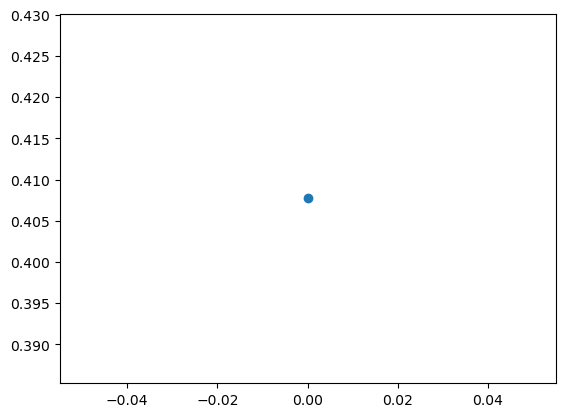

  6%|████▉                                                                              | 1/17 [00:01<00:20,  1.27s/it]

 Shape New Array (1147, 2) (1147, 2)
Reprojection Error:  0.38810521863609804


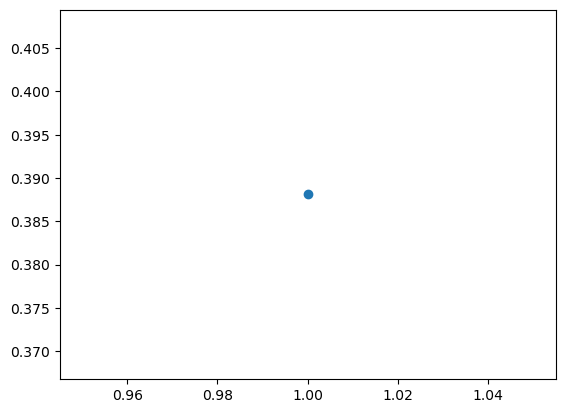

 12%|█████████▊                                                                         | 2/17 [00:02<00:18,  1.23s/it]

 Shape New Array (531, 2) (531, 2)
Reprojection Error:  6.285247210009738


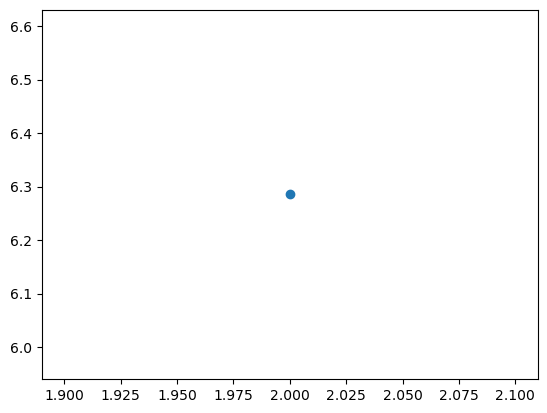

 18%|██████████████▋                                                                    | 3/17 [00:03<00:16,  1.20s/it]

 Shape New Array (1100, 2) (1100, 2)
Reprojection Error:  0.7319263670933964


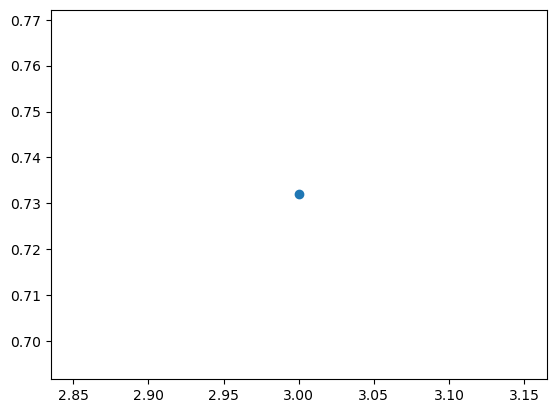

 24%|███████████████████▌                                                               | 4/17 [00:04<00:15,  1.18s/it]

 Shape New Array (855, 2) (855, 2)
Reprojection Error:  1.3941091685183684


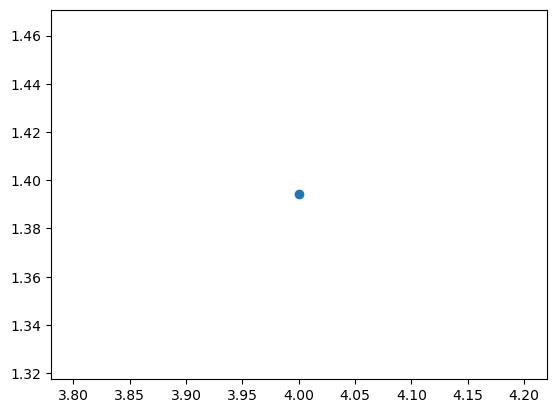

 29%|████████████████████████▍                                                          | 5/17 [00:06<00:14,  1.20s/it]

 Shape New Array (673, 2) (673, 2)
Reprojection Error:  1.3521127299286477


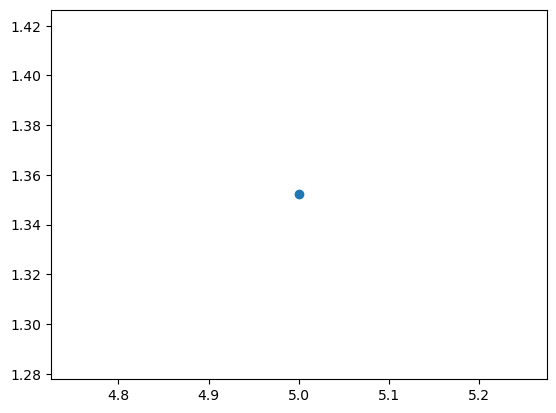

 35%|█████████████████████████████▎                                                     | 6/17 [00:07<00:13,  1.20s/it]

 Shape New Array (722, 2) (722, 2)
Reprojection Error:  11.158646901353285


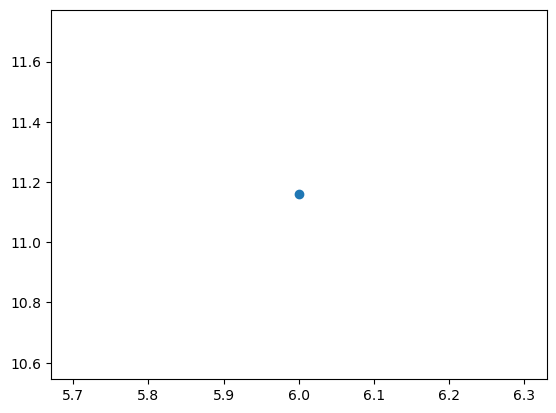

 41%|██████████████████████████████████▏                                                | 7/17 [00:08<00:11,  1.18s/it]

 Shape New Array (637, 2) (637, 2)
Reprojection Error:  6.764909616437433


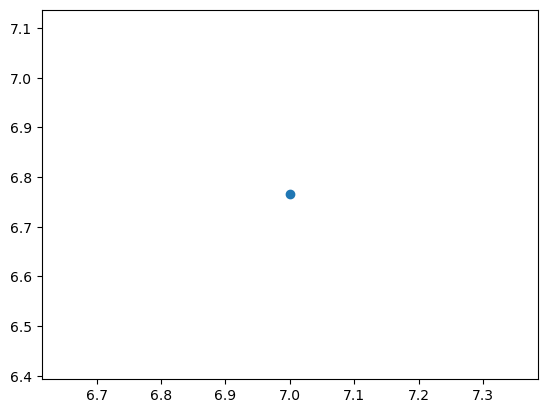

 47%|███████████████████████████████████████                                            | 8/17 [00:09<00:10,  1.19s/it]

 Shape New Array (459, 2) (459, 2)
Reprojection Error:  6.907059283943491


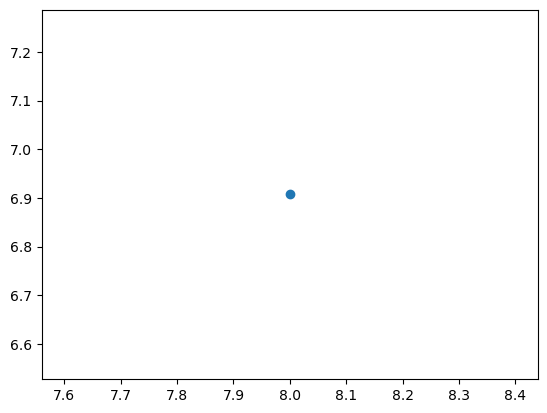

 53%|███████████████████████████████████████████▉                                       | 9/17 [00:10<00:09,  1.18s/it]

 Shape New Array (248, 2) (248, 2)
Reprojection Error:  211.44855846855816


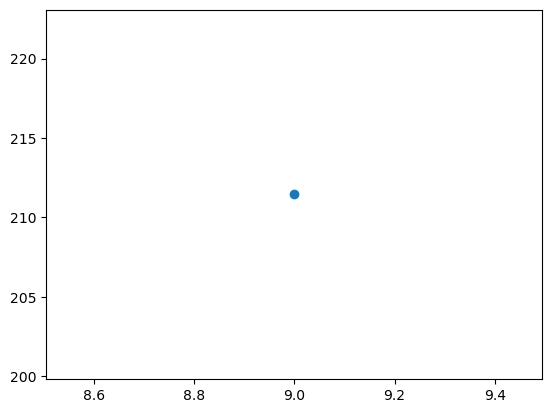

 59%|████████████████████████████████████████████████▏                                 | 10/17 [00:11<00:08,  1.16s/it]

 Shape New Array (153, 2) (153, 2)
Reprojection Error:  10.328162357934756


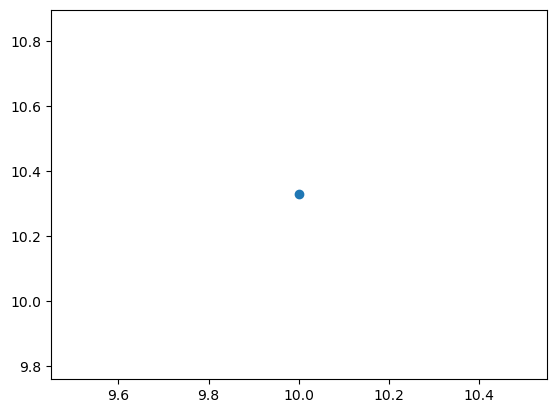

 65%|█████████████████████████████████████████████████████                             | 11/17 [00:12<00:06,  1.13s/it]

 Shape New Array (413, 2) (413, 2)
Reprojection Error:  7.857260804257516


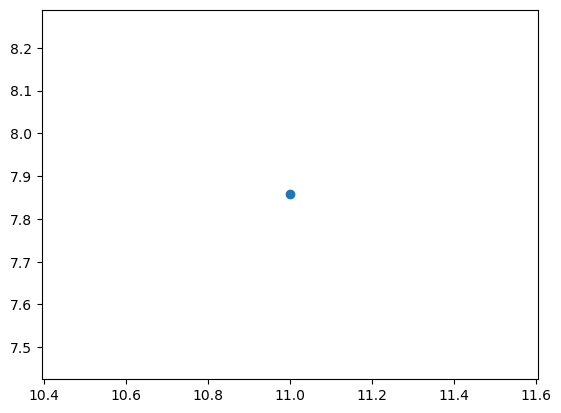

 71%|█████████████████████████████████████████████████████████▉                        | 12/17 [00:14<00:05,  1.12s/it]

 Shape New Array (553, 2) (553, 2)
Reprojection Error:  4568.16433915743


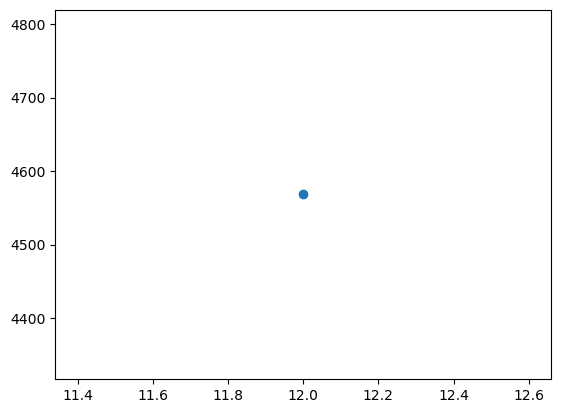

 76%|██████████████████████████████████████████████████████████████▋                   | 13/17 [00:15<00:04,  1.10s/it]

 Shape New Array (230, 2) (230, 2)
Reprojection Error:  78.09960632573632


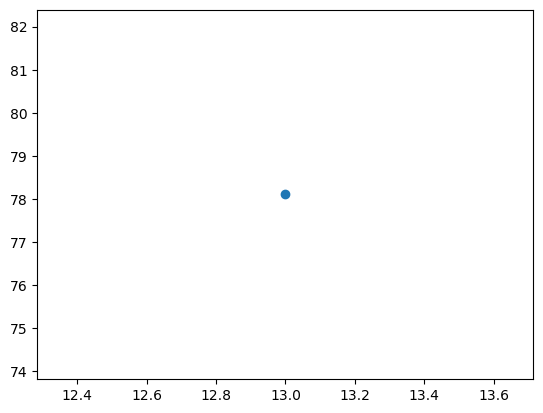

 82%|███████████████████████████████████████████████████████████████████▌              | 14/17 [00:16<00:03,  1.11s/it]

 Shape New Array (480, 2) (480, 2)
Reprojection Error:  35.30102824077131


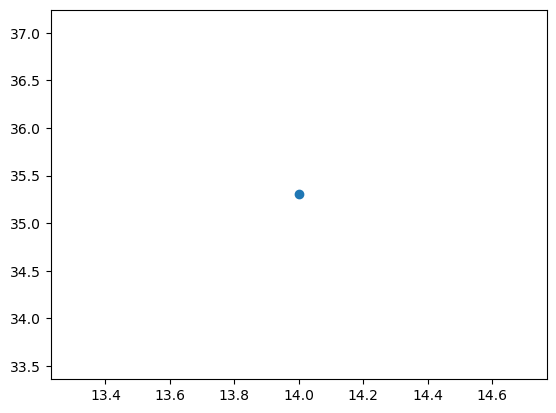

 88%|████████████████████████████████████████████████████████████████████████▎         | 15/17 [00:17<00:02,  1.11s/it]

 Shape New Array (527, 2) (527, 2)
Reprojection Error:  4.994442360951383


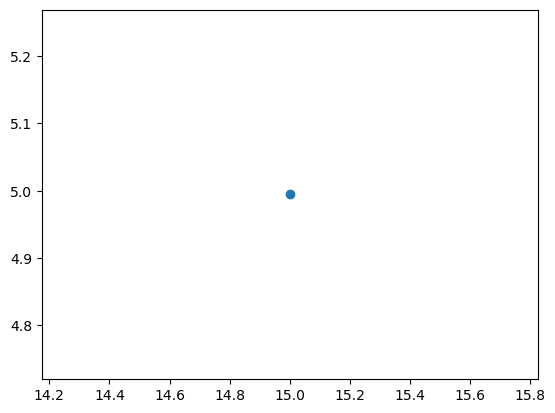

 94%|█████████████████████████████████████████████████████████████████████████████▏    | 16/17 [00:18<00:01,  1.16s/it]

 Shape New Array (503, 2) (503, 2)
Reprojection Error:  3.0472824915185983


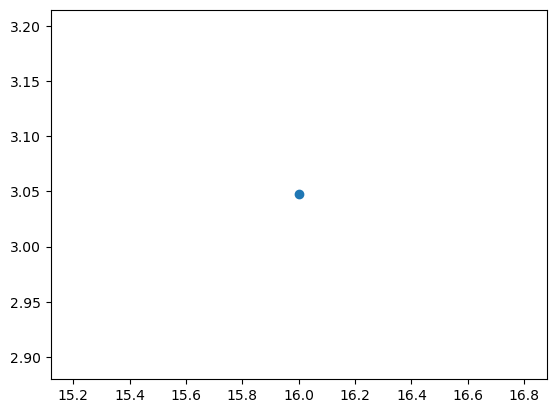

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.16s/it]

Printing to .ply file
(10331, 3) (10331, 3)
@@@@@@@@@@@@@@@@
castle-P19
(10331, 3) (10331, 3)
Completed Exiting ...
end-------------------


In [12]:
sfm('Datasets/castle-P19', 2.0)